In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

In [24]:
df = pd.read_csv('GL_3_merged.csv')

In [25]:
df.head()

,Unnamed: 0.1,Unnamed: 0,title,author,year,publication_year,description,Genre,Author_Rating,total_weeks,...,Sales_Rank,Duyet_Commercial_Success,Khang_Commercial_Success,Kiet_Commercial_Success,Duyet_Popular_Success,Khang_Popular_Success,Kiet_Popular_Success,Duyet_Critical_Success,Khang_Critical_Success,Kiet_Critical_Success
0,0,2029,A Breath Of Snow And Ashes,Diana Gabaldon,2005,2005,A Breath of Snow and Ashescontinues the extrao...,Nonfiction,Famous,5,...,547,4,4,4,3,4,3,5,5,5
1,1,1966,A Crown Of Swords,Robert Jordan,1996,2013,"The Wheel of Time, Robert Jordan's internation...",Nonfiction,Intermediate,8,...,661,5,5,5,3,3,3,3,3,3
2,2,1857,A Memory Of Light,Robert Jordan and Brandon Sanderson,2013,2015,"Since 1990, when Robert Jordan's The Wheel of ...",Fiction,Famous,12,...,986,2,3,3,4,4,5,5,5,5
3,3,1627,Bet Me,Jennifer Crusie,2004,2004,Minerva Dobbs knows that happily-ever-after is...,Fiction,Intermediate,3,...,1266,1,1,1,2,2,2,3,3,4
4,4,1636,Cell,Stephen King,2006,2006,"Boston, primo ottobre. Tutto va bene. E un lum...",Fiction,Intermediate,9,...,80,2,2,2,3,4,4,2,2,2


In [26]:
df.shape

(50, 33)

In [27]:
df = df.rename(columns={
    'Duyet_Commercial_Success': 'Duyet_Commercial',
    'Duyet_Popular_Success': 'Duyet_Public',
    'Duyet_Critical_Success': 'Duyet_Critical',
    'Khang_Commercial_Success': 'Khang_Commercial',
    'Khang_Popular_Success': 'Khang_Public',
    'Khang_Critical_Success': 'Khang_Critical',
    'Kiet_Commercial_Success': 'Kiet_Commercial',
    'Kiet_Popular_Success': 'Kiet_Public',
    'Kiet_Critical_Success': 'Kiet_Critical'
})

In [28]:
annotators = ['Duyet', 'Khang', 'Kiet']
fields = ['Commercial', 'Public', 'Critical']  
choices = ['1', '2', '3', '4', '5']

In [29]:
def fleiss_kappa(M):
    N, k = M.shape
    n_annotators = np.sum(M[0])
    P = np.sum(M, axis=0) / (N * n_annotators)
    P_i = (np.sum(M * M, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))
    P_bar = np.mean(P_i)
    P_e = np.sum(P * P)
    kappa = (P_bar - P_e) / (1 - P_e) if (1 - P_e) != 0 else np.nan
    return kappa

In [30]:
kappa_results = {}
for field in fields:
    cols = [f'{ann}_{field}' for ann in annotators]
    
    # Bảng tổng hợp annotator x choice
    rows = []
    for col in cols:
        counts = {c: 0 for c in choices}
        for val in df[col].dropna().astype(str):
            if val in choices:
                counts[val] += 1
        rows.append([counts[c] for c in choices])
    
    df_table = pd.DataFrame(rows, columns=choices, index=annotators)
    df_table.index.name = 'Annotator'
    print(f'Bảng tổng hợp cho trường: {field} Success')
    display(df_table)
    
    # Ma trận cho Fleiss: mỗi dòng là 1 item, mỗi cột là count choice
    M = np.zeros((len(df), len(choices)), dtype=int)
    for i in range(len(df)):
        for j, col in enumerate(cols):
            val = str(df.at[i, col])
            if val in choices:
                idx = choices.index(val)
                M[i, idx] += 1
    
    kappa = fleiss_kappa(M)
    kappa_results[field] = kappa
    print(f"Fleiss' kappa cho trường {field} Success: {kappa:.4f}\n")


Bảng tổng hợp cho trường: Commercial Success


,1,2,3,4,5
Annotator,,,,,
Duyet,10,8,7,16,9
Khang,10,7,6,18,9
Kiet,10,7,6,16,11


Fleiss' kappa cho trường Commercial Success: 0.9225

Bảng tổng hợp cho trường: Public Success


,1,2,3,4,5
Annotator,,,,,
Duyet,10,13,12,9,6
Khang,7,15,9,15,4
Kiet,5,13,13,9,10


Fleiss' kappa cho trường Public Success: 0.6693

Bảng tổng hợp cho trường: Critical Success


,1,2,3,4,5
Annotator,,,,,
Duyet,5,12,14,10,9
Khang,5,10,15,11,9
Kiet,4,10,14,13,9


Fleiss' kappa cho trường Critical Success: 0.8376



In [31]:
kappa_df = pd.DataFrame.from_dict(kappa_results, orient='index', columns=["Fleiss' kappa"])
kappa_df.index = [f'{f} Success' for f in kappa_results]
display(kappa_df)


,Fleiss' kappa
Commercial Success,0.922476
Public Success,0.669305
Critical Success,0.837570


--- Phân tích trường: Commercial Success ---


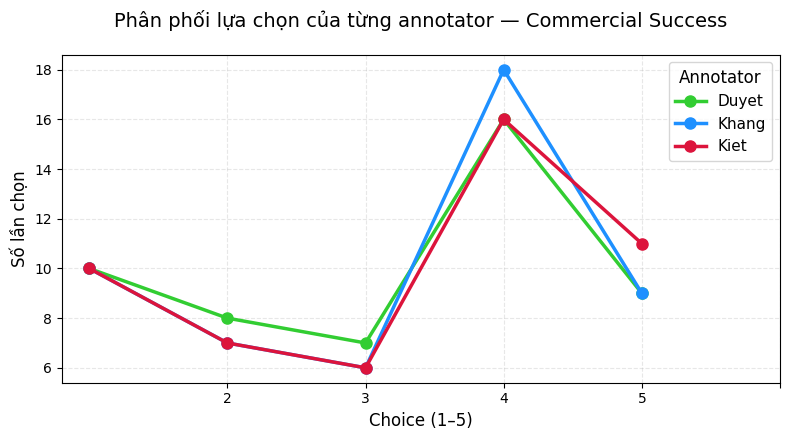

Số item bất đồng hoàn toàn (cả 3 chọn khác nhau): 1 / 50
   Ví dụ index: [16]
Tỉ lệ đồng thuận giữa các cặp annotator:
   Duyet vs Khang: 47/50 = 94.00%
   Duyet vs Kiet: 46/50 = 92.00%
   Khang vs Kiet: 48/50 = 96.00%


--- Phân tích trường: Public Success ---


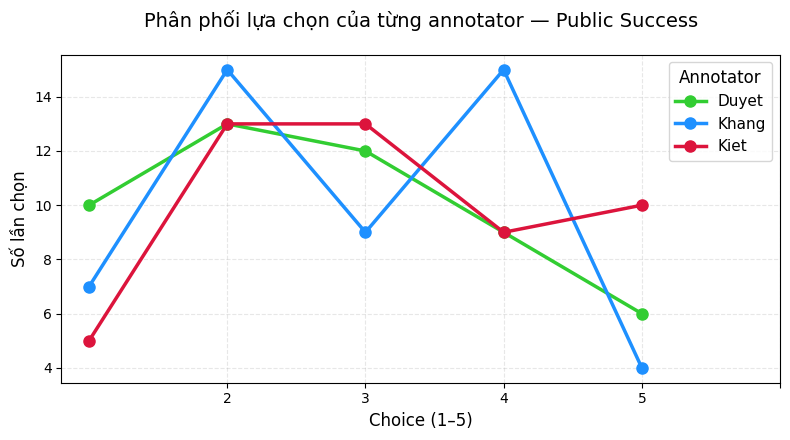

Số item bất đồng hoàn toàn (cả 3 chọn khác nhau): 3 / 50
   Ví dụ index: [16, 41, 47]
Tỉ lệ đồng thuận giữa các cặp annotator:
   Duyet vs Khang: 41/50 = 82.00%
   Duyet vs Kiet: 35/50 = 70.00%
   Khang vs Kiet: 35/50 = 70.00%


--- Phân tích trường: Critical Success ---


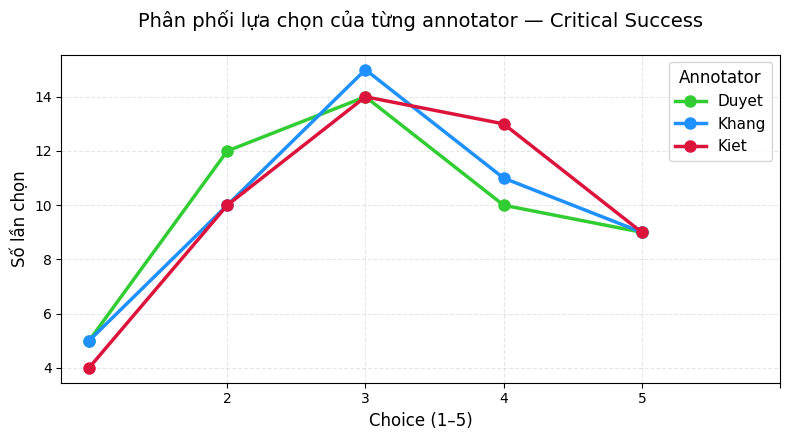

Số item bất đồng hoàn toàn (cả 3 chọn khác nhau): 1 / 50
   Ví dụ index: [9]
Tỉ lệ đồng thuận giữa các cặp annotator:
   Duyet vs Khang: 43/50 = 86.00%
   Duyet vs Kiet: 44/50 = 88.00%
   Khang vs Kiet: 44/50 = 88.00%




In [32]:
# EDA: Phân tích phân phối lựa chọn của từng annotator (sửa lỗi plot)
for field in fields:
    print(f"--- Phân tích trường: {field} Success ---")
    cols = [f'{ann}_{field}' for ann in annotators]
    
    plt.figure(figsize=(8, 4.5))
    
    color_map = {'Duyet': 'limegreen', 'Khang': 'dodgerblue', 'Kiet': 'crimson'}
    
    for col in cols:
        annotator = col.split('_')[0]
        # Đếm tần suất từng choice (1 đến 5), đảm bảo đủ 5 giá trị
        counts = df[col].astype(str).value_counts().reindex(choices, fill_value=0).sort_index()
        # Chuyển counts.values thành int để tránh lỗi plot
        plt.plot(counts.index, counts.values.astype(int), 
                 marker='o', linewidth=2.5, markersize=8,
                 label=annotator, color=color_map.get(annotator))
    
    plt.title(f'Phân phối lựa chọn của từng annotator — {field} Success', fontsize=14, pad=20)
    plt.xlabel('Choice (1–5)', fontsize=12)
    plt.ylabel('Số lần chọn', fontsize=12)
    plt.xticks(range(1, 6))  # Đảm bảo trục x hiển thị đúng 1,2,3,4,5
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(title='Annotator', title_fontsize=12, fontsize=11, loc='upper right')
    plt.tight_layout()
    plt.show()
    
    # Phân tích item bất đồng hoàn toàn (cả 3 chọn khác nhau)
    disagreement_items = []
    for i in range(len(df)):
        vals = []
        for col in cols:
            val = str(df.at[i, col])
            if val in choices:
                vals.append(val)
        if len(vals) == 3 and len(set(vals)) == 3:  # đủ 3 và tất cả khác nhau
            disagreement_items.append(i)
    
    print(f"Số item bất đồng hoàn toàn (cả 3 chọn khác nhau): {len(disagreement_items)} / {len(df)}")
    if disagreement_items:
        print(f"   Ví dụ index: {disagreement_items[:10]}{'...' if len(disagreement_items) > 10 else ''}")
    
    # Tỉ lệ đồng thuận pairwise
    print("Tỉ lệ đồng thuận giữa các cặp annotator:")
    for a1, a2 in combinations(annotators, 2):
        col1 = f'{a1}_{field}'
        col2 = f'{a2}_{field}'
        mask = df[col1].notna() & df[col2].notna()
        if mask.sum() == 0:
            print(f"   {a1} vs {a2}: Không có dữ liệu chung")
            continue
        agree_count = (df.loc[mask, col1] == df.loc[mask, col2]).sum()
        total = mask.sum()
        agree_pct = agree_count / total
        print(f"   {a1} vs {a2}: {agree_count}/{total} = {agree_pct:.2%}")
    
    print("\n")

--- So sánh chi tiết giữa Duyet và các annotator cho trường: Commercial Success ---

Biểu đồ confusion giữa Duyet và Khang:


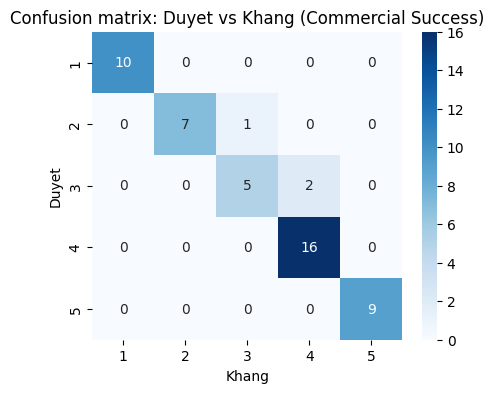

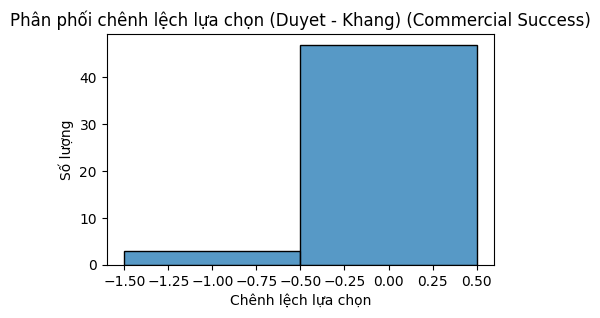

Số trường hợp bất đồng lớn nhất (|chênh lệch|=1): 3
Vị trí các item bất đồng lớn nhất: [2, 16, 32] 

Biểu đồ confusion giữa Duyet và Kiet:


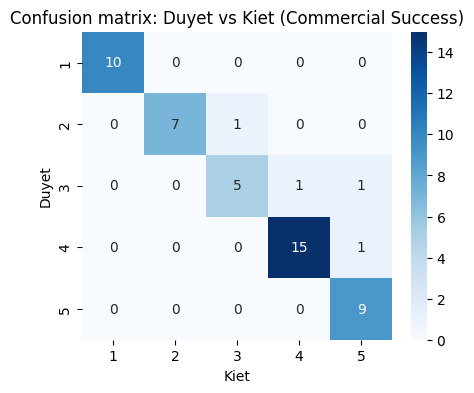

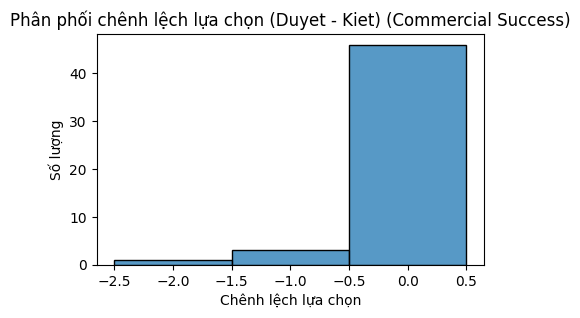

Số trường hợp bất đồng lớn nhất (|chênh lệch|=2): 1
Vị trí các item bất đồng lớn nhất: [16] 

--- So sánh chi tiết giữa Duyet và các annotator cho trường: Public Success ---

Biểu đồ confusion giữa Duyet và Khang:


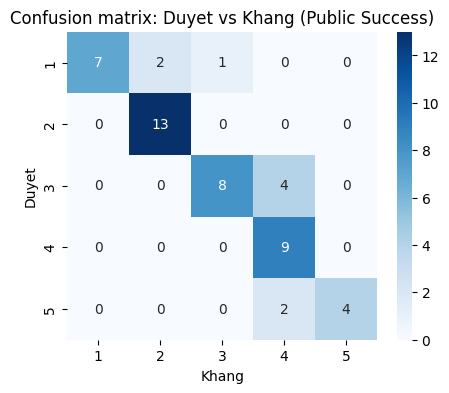

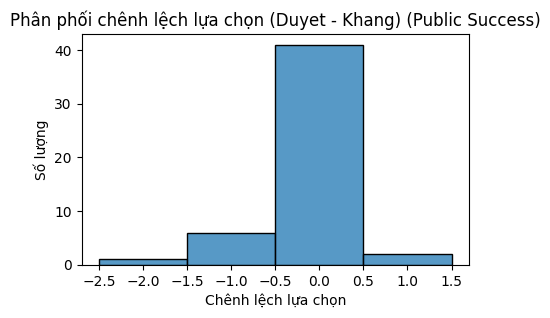

Số trường hợp bất đồng lớn nhất (|chênh lệch|=2): 1
Vị trí các item bất đồng lớn nhất: [47] 

Biểu đồ confusion giữa Duyet và Kiet:


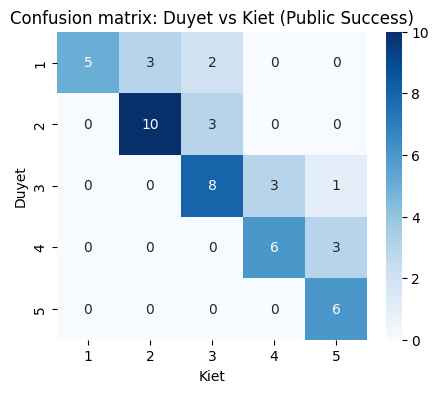

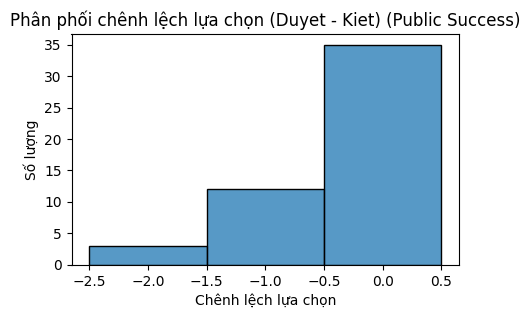

Số trường hợp bất đồng lớn nhất (|chênh lệch|=2): 3
Vị trí các item bất đồng lớn nhất: [16, 28, 41] 

--- So sánh chi tiết giữa Duyet và các annotator cho trường: Critical Success ---

Biểu đồ confusion giữa Duyet và Khang:


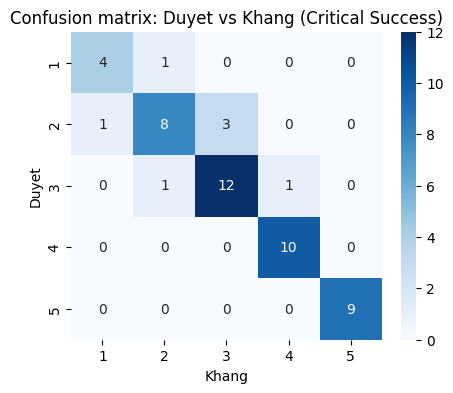

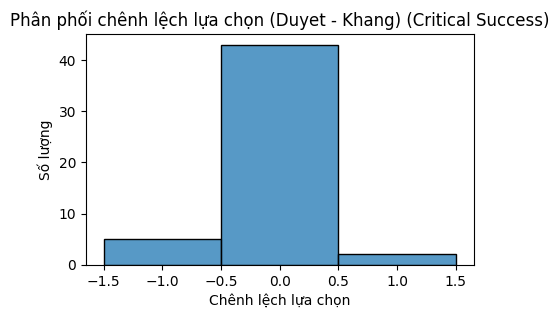

Số trường hợp bất đồng lớn nhất (|chênh lệch|=1): 7
Vị trí các item bất đồng lớn nhất: [9, 12, 18, 28, 37, 44, 47] 

Biểu đồ confusion giữa Duyet và Kiet:


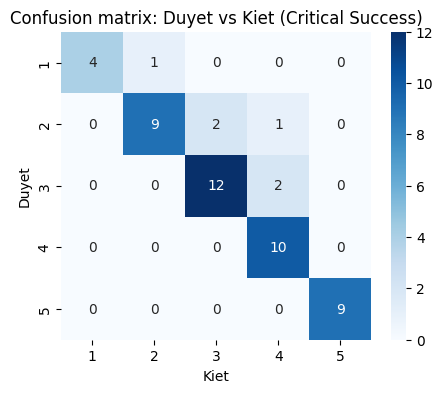

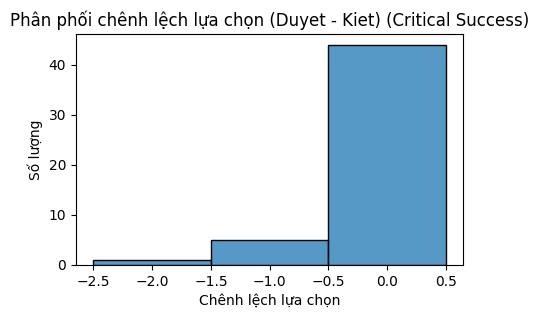

Số trường hợp bất đồng lớn nhất (|chênh lệch|=2): 1
Vị trí các item bất đồng lớn nhất: [9] 



In [33]:
for field in fields:
    print(f"--- So sánh chi tiết giữa Duyet và các annotator cho trường: {field} Success ---")
    cols = [f'{ann}_{field}' for ann in annotators]
    
    for other in ['Khang', 'Kiet']:
        col1 = f'Duyet_{field}'
        col2 = f'{other}_{field}'
        mask = df[col1].notna() & df[col2].notna()
        c1_valid = df.loc[mask, col1].astype(str)
        c2_valid = df.loc[mask, col2].astype(str)
        
        print(f"\nBiểu đồ confusion giữa Duyet và {other}:")
        cm = pd.crosstab(c1_valid, c2_valid, rownames=['Duyet'], colnames=[other])
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion matrix: Duyet vs {other} ({field} Success)')
        plt.show()
        
        diff = c1_valid.astype(int) - c2_valid.astype(int)
        plt.figure(figsize=(5,3))
        sns.histplot(diff, bins=np.arange(diff.min()-0.5, diff.max()+1.5), kde=False)
        plt.title(f'Phân phối chênh lệch lựa chọn (Duyet - {other}) ({field} Success)')
        plt.xlabel('Chênh lệch lựa chọn')
        plt.ylabel('Số lượng')
        plt.show()
        
        abs_diff = np.abs(diff)
        max_diff = abs_diff.max() if len(abs_diff) > 0 else 0
        idxs = np.where(abs_diff == max_diff)[0]
        print(f"Số trường hợp bất đồng lớn nhất (|chênh lệch|={max_diff}): {len(idxs)}")
        if len(idxs) > 0:
            print("Vị trí các item bất đồng lớn nhất:", idxs[:10].tolist(), "..." if len(idxs) > 10 else "")
    print()